In [ ]:
import os
import math
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from itertools import cycle
from torchinfo import summary
from datetime import timedelta
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from torchvision import datasets, transforms
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/lungcancer4types-imagedataset
/kaggle/input/lungcancer4types-imagedataset/Data
/kaggle/input/lungcancer4types-imagedataset/Data/valid
/kaggle/input/lungcancer4types-imagedataset/Data/test
/kaggle/input/lungcancer4types-imagedataset/Data/train
/kaggle/input/lungcancer4types-imagedataset/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/lungcancer4types-imagedataset/Data/valid/normal
/kaggle/input/lungcancer4types-imagedataset/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/lungcancer4types-imagedataset/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/kaggle/input/lungcancer4types-imagedataset/Data/test/squamous.cell.carcinoma
/kaggle/input/lungcancer4types-imagedataset/Data/test/normal
/kaggle/input/lungcancer4types-imagedataset/Data/test/adenocarcinoma
/kaggle/input/lungcancer4types-imagedataset/Data/test/large.cell.carcinoma
/kaggle/input/lungcancer4types-imagedataset/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2

In [ ]:
def compute_normalization_stats(dataset_dir, batch_size=32, num_workers=4, image_size=(224, 224)):
    """
    Compute per-channel mean and std for a dataset.
    Images are resized to a fixed size to avoid collation issues.
    """
    temp_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_dir, transform=temp_transform)
    temp_loader = DataLoader(
        temp_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    mean = 0.0
    std = 0.0
    nb_samples = 0

    with torch.no_grad():
        for images, _ in temp_loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

def create_transforms(mean, std, image_size=(224, 224)):
    """
    Create training and validation/test transforms using computed statistics.
    """
    train_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    val_test_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    return train_transforms, val_test_transforms

def create_datasets_and_loaders(train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=32, num_workers=4):
    """
    Create ImageFolder datasets and DataLoaders with pinned memory.
    """
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=val_test_transforms)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [5]:
def plot_class_distribution(train_dataset, valid_dataset, test_dataset):
    """
    Plot class distribution across train, validation, and test splits.
    """
    train_targets = np.array(train_dataset.targets)
    valid_targets = np.array(valid_dataset.targets)
    test_targets  = np.array(test_dataset.targets)
    
    classes = train_dataset.classes
    num_classes = len(classes)
    
    train_counts = np.bincount(train_targets, minlength=num_classes)
    valid_counts = np.bincount(valid_targets, minlength=num_classes)
    test_counts  = np.bincount(test_targets, minlength=num_classes)
    
    df = pd.DataFrame({
        'Class': classes,
        'Train': train_counts,
        'Validation': valid_counts,
        'Test': test_counts
    })
    print(df)
    
    x = np.arange(num_classes)
    bar_width = 0.6
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, train_counts, bar_width, color='blue', label='Train')
    plt.bar(x, valid_counts, bar_width, bottom=train_counts, color='green', label='Validation')
    plt.bar(x, test_counts, bar_width, bottom=train_counts + valid_counts, color='red', label='Test')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(x, classes, rotation=45)
    plt.title('Stacked Class-wise Distribution: Train, Validation, and Test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
data_dir = '/kaggle/input/lungcancer4types-imagedataset/Data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

In [ ]:
mean, std = compute_normalization_stats(train_dir, batch_size=32, num_workers=4, image_size=(224, 224))
print("Computed Mean:", mean)
print("Computed Std:", std)

train_transforms, val_test_transforms = create_transforms(mean, std, image_size=(224, 224))

batch_size = 32
num_workers = 4
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = create_datasets_and_loaders(
    train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=batch_size, num_workers=num_workers)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))

Computed Mean: tensor([0.3230, 0.3230, 0.3230])
Computed Std: tensor([0.2216, 0.2216, 0.2216])
Training samples: 613
Validation samples: 72
Test samples: 315


                                              Class  Train  Validation  Test
0        adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib    195          23   120
1     large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa    115          21    51
2                                            normal    148          13    54
3  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    155          15    90


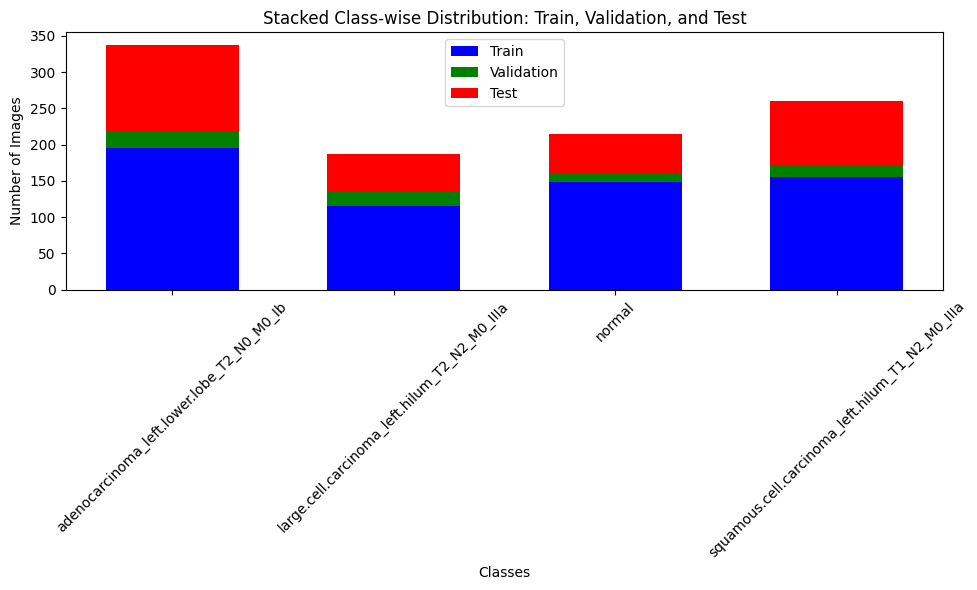

In [ ]:
plot_class_distribution(train_dataset, valid_dataset, test_dataset)

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

num_classes = 10 

model.heads = nn.Sequential(
    nn.Linear(model.heads[0].in_features, num_classes)
)

model = model.to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 10]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    if cm.shape[0] == 2 and cm.shape[1] == 2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = None
        sensitivity = None

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []
    unique_classes = np.unique(y_true_numpy)
    if len(unique_classes) > 1:
        for class_idx in range(num_classes):
            class_y_true = (y_true_numpy == class_idx).astype(np.float32)
            class_y_pred = y_pred[:, class_idx].cpu().numpy()
            if np.all(class_y_true == 0) or np.all(class_y_true == 1):
                continue
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        auc_avg = np.nanmean(auc_scores) if auc_scores else None
    else:
        auc_avg = None

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 35 
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device).long()  
        
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    
    training_metrics_line = "Training Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_value is None:
            training_metrics_line += f"{metric_name}: N/A, "
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(valid_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device).long() 
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(valid_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Validation Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_value is None:
            validation_metrics_line += f"{metric_name}: N/A, "
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/35]: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Training Metrics - loss: 1.3627, accuracy: 0.4388, precision: 0.4817, recall: 0.4388, f1_score: 0.4335, specificity: N/A, sensitivity: N/A, mcc: 0.2450, auc: 0.6270, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Validation Metrics - loss: 1.0399, accuracy: 0.5556, precision: 0.5625, recall: 0.5556, f1_score: 0.5315, specificity: N/A, sensitivity: N/A, mcc: 0.4115, auc: 0.7757, 


Training Model - Epoch [2/35]: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Training Metrics - loss: 0.7892, accuracy: 0.6852, precision: 0.6932, recall: 0.6852, f1_score: 0.6569, specificity: N/A, sensitivity: N/A, mcc: 0.5801, auc: 0.8747, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Validation Metrics - loss: 0.8289, accuracy: 0.5556, precision: 0.6669, recall: 0.5556, f1_score: 0.5524, specificity: N/A, sensitivity: N/A, mcc: 0.4532, auc: 0.8286, 


Training Model - Epoch [3/35]: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Training Metrics - loss: 0.5296, accuracy: 0.8287, precision: 0.8363, recall: 0.8287, f1_score: 0.8254, specificity: N/A, sensitivity: N/A, mcc: 0.7704, auc: 0.9432, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


Validation Metrics - loss: 0.6921, accuracy: 0.6250, precision: 0.6986, recall: 0.6250, f1_score: 0.6255, specificity: N/A, sensitivity: N/A, mcc: 0.5130, auc: 0.8741, 


Training Model - Epoch [4/35]: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Training Metrics - loss: 0.3096, accuracy: 0.9347, precision: 0.9346, recall: 0.9347, f1_score: 0.9341, specificity: N/A, sensitivity: N/A, mcc: 0.9121, auc: 0.9802, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Validation Metrics - loss: 0.5943, accuracy: 0.6528, precision: 0.7507, recall: 0.6528, f1_score: 0.6346, specificity: N/A, sensitivity: N/A, mcc: 0.5569, auc: 0.9132, 


Training Model - Epoch [5/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.1643, accuracy: 0.9657, precision: 0.9660, recall: 0.9657, f1_score: 0.9654, specificity: N/A, sensitivity: N/A, mcc: 0.9540, auc: 0.9964, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Validation Metrics - loss: 0.6668, accuracy: 0.7222, precision: 0.7733, recall: 0.7222, f1_score: 0.7143, specificity: N/A, sensitivity: N/A, mcc: 0.6423, auc: 0.9238, 


Training Model - Epoch [6/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.1267, accuracy: 0.9674, precision: 0.9674, recall: 0.9674, f1_score: 0.9674, specificity: N/A, sensitivity: N/A, mcc: 0.9560, auc: 0.9974, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Validation Metrics - loss: 0.8449, accuracy: 0.7639, precision: 0.8481, recall: 0.7639, f1_score: 0.7557, specificity: N/A, sensitivity: N/A, mcc: 0.7144, auc: 0.9376, 


Training Model - Epoch [7/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0761, accuracy: 0.9886, precision: 0.9886, recall: 0.9886, f1_score: 0.9886, specificity: N/A, sensitivity: N/A, mcc: 0.9846, auc: 0.9996, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Validation Metrics - loss: 0.3795, accuracy: 0.8056, precision: 0.8279, recall: 0.8056, f1_score: 0.8118, specificity: N/A, sensitivity: N/A, mcc: 0.7412, auc: 0.9525, 


Training Model - Epoch [8/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0377, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Validation Metrics - loss: 0.3633, accuracy: 0.8472, precision: 0.8750, recall: 0.8472, f1_score: 0.8533, specificity: N/A, sensitivity: N/A, mcc: 0.8006, auc: 0.9549, 


Training Model - Epoch [9/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0255, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Validation Metrics - loss: 0.3681, accuracy: 0.8333, precision: 0.8626, recall: 0.8333, f1_score: 0.8388, specificity: N/A, sensitivity: N/A, mcc: 0.7823, auc: 0.9584, 


Training Model - Epoch [10/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0217, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: N/A, sensitivity: N/A, mcc: 0.9956, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Validation Metrics - loss: 0.3764, accuracy: 0.8333, precision: 0.8706, recall: 0.8333, f1_score: 0.8389, specificity: N/A, sensitivity: N/A, mcc: 0.7869, auc: 0.9584, 


Training Model - Epoch [11/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0159, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Validation Metrics - loss: 0.3584, accuracy: 0.8472, precision: 0.8690, recall: 0.8472, f1_score: 0.8518, specificity: N/A, sensitivity: N/A, mcc: 0.7988, auc: 0.9620, 


Training Model - Epoch [12/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0137, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: N/A, sensitivity: N/A, mcc: 0.9956, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Validation Metrics - loss: 0.3534, accuracy: 0.8472, precision: 0.8677, recall: 0.8472, f1_score: 0.8504, specificity: N/A, sensitivity: N/A, mcc: 0.7982, auc: 0.9629, 


Training Model - Epoch [13/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0113, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Validation Metrics - loss: 0.3683, accuracy: 0.8333, precision: 0.8576, recall: 0.8333, f1_score: 0.8376, specificity: N/A, sensitivity: N/A, mcc: 0.7807, auc: 0.9619, 


Training Model - Epoch [14/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0099, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Validation Metrics - loss: 0.3644, accuracy: 0.8333, precision: 0.8576, recall: 0.8333, f1_score: 0.8376, specificity: N/A, sensitivity: N/A, mcc: 0.7807, auc: 0.9633, 


Training Model - Epoch [15/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0089, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: N/A, sensitivity: N/A, mcc: 1.0000, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Validation Metrics - loss: 0.3730, accuracy: 0.8333, precision: 0.8576, recall: 0.8333, f1_score: 0.8376, specificity: N/A, sensitivity: N/A, mcc: 0.7807, auc: 0.9624, 


Training Model - Epoch [16/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0079, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Validation Metrics - loss: 0.3858, accuracy: 0.8194, precision: 0.8480, recall: 0.8194, f1_score: 0.8246, specificity: N/A, sensitivity: N/A, mcc: 0.7635, auc: 0.9629, 


Training Model - Epoch [17/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0094, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: N/A, sensitivity: N/A, mcc: 0.9956, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Validation Metrics - loss: 0.3882, accuracy: 0.8333, precision: 0.8626, recall: 0.8333, f1_score: 0.8388, specificity: N/A, sensitivity: N/A, mcc: 0.7823, auc: 0.9633, 


Training Model - Epoch [18/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0066, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Validation Metrics - loss: 0.3719, accuracy: 0.8611, precision: 0.8773, recall: 0.8611, f1_score: 0.8628, specificity: N/A, sensitivity: N/A, mcc: 0.8159, auc: 0.9626, 


Training Model - Epoch [19/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0259, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


Validation Metrics - loss: 0.4403, accuracy: 0.8194, precision: 0.8653, recall: 0.8194, f1_score: 0.8258, specificity: N/A, sensitivity: N/A, mcc: 0.7713, auc: 0.9642, 


Training Model - Epoch [20/35]: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Training Metrics - loss: 0.0187, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 0.9998, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


Validation Metrics - loss: 0.4446, accuracy: 0.8333, precision: 0.8728, recall: 0.8333, f1_score: 0.8385, specificity: N/A, sensitivity: N/A, mcc: 0.7874, auc: 0.9607, 


Training Model - Epoch [21/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0144, accuracy: 0.9967, precision: 0.9968, recall: 0.9967, f1_score: 0.9967, specificity: N/A, sensitivity: N/A, mcc: 0.9956, auc: 0.9997, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


Validation Metrics - loss: 0.4553, accuracy: 0.8194, precision: 0.8480, recall: 0.8194, f1_score: 0.8246, specificity: N/A, sensitivity: N/A, mcc: 0.7635, auc: 0.9558, 


Training Model - Epoch [22/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0087, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 0.9997, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Validation Metrics - loss: 0.4141, accuracy: 0.8611, precision: 0.8773, recall: 0.8611, f1_score: 0.8628, specificity: N/A, sensitivity: N/A, mcc: 0.8159, auc: 0.9618, 


Training Model - Epoch [23/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0075, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 0.9999, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Validation Metrics - loss: 0.3830, accuracy: 0.8333, precision: 0.8576, recall: 0.8333, f1_score: 0.8376, specificity: N/A, sensitivity: N/A, mcc: 0.7807, auc: 0.9632, 


Training Model - Epoch [24/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0070, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 0.9999, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Validation Metrics - loss: 0.3883, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9634, 


Training Model - Epoch [25/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0063, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Validation Metrics - loss: 0.3864, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9633, 


Training Model - Epoch [26/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0059, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Validation Metrics - loss: 0.3782, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9631, 


Training Model - Epoch [27/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0056, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Validation Metrics - loss: 0.3876, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9642, 


Training Model - Epoch [28/35]: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Training Metrics - loss: 0.0054, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Validation Metrics - loss: 0.3903, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9644, 


Training Model - Epoch [29/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0056, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Validation Metrics - loss: 0.3906, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9648, 


Training Model - Epoch [30/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0051, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Validation Metrics - loss: 0.3850, accuracy: 0.8611, precision: 0.8773, recall: 0.8611, f1_score: 0.8628, specificity: N/A, sensitivity: N/A, mcc: 0.8159, auc: 0.9646, 


Training Model - Epoch [31/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0048, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Validation Metrics - loss: 0.3891, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9646, 


Training Model - Epoch [32/35]: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Training Metrics - loss: 0.0047, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Validation Metrics - loss: 0.3988, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9651, 


Training Model - Epoch [33/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0046, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]


Validation Metrics - loss: 0.3949, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9644, 


Training Model - Epoch [34/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0043, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: N/A, sensitivity: N/A, mcc: 0.9978, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Validation Metrics - loss: 0.3942, accuracy: 0.8472, precision: 0.8655, recall: 0.8472, f1_score: 0.8498, specificity: N/A, sensitivity: N/A, mcc: 0.7974, auc: 0.9641, 


Training Model - Epoch [35/35]: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Training Metrics - loss: 0.0045, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: N/A, sensitivity: N/A, mcc: 0.9956, auc: 1.0000, 


Validating Model: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

Validation Metrics - loss: 0.3920, accuracy: 0.8611, precision: 0.8773, recall: 0.8611, f1_score: 0.8628, specificity: N/A, sensitivity: N/A, mcc: 0.8159, auc: 0.9641, 
Total Training Time: 0:07:08.550494
Total Validation Time: 0:00:26.392859
Average Training Time per Epoch: 0:00:12.244300
Average Validation Time per Epoch: 0:00:00.754082


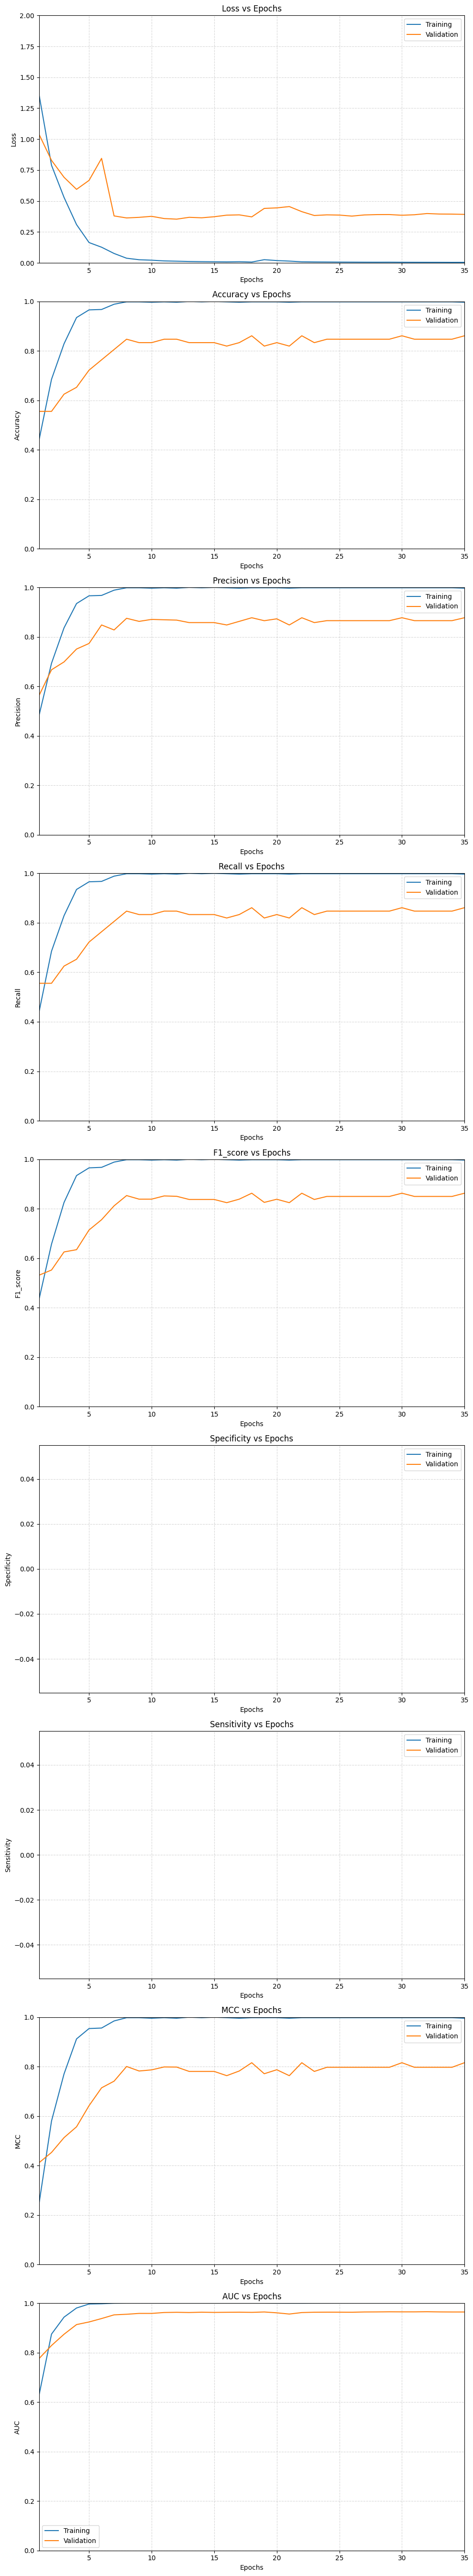

In [ ]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    
    if num_metrics == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    
    rng = range(1, num_epochs + 1)
    
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        
        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")
        
        valid_train = [m for m in train_metric if m is not None]
        valid_val = [m for m in val_metric if m is not None]
        
        if valid_train or valid_val:
            max_metric = max((max(valid_train) if valid_train else float('-inf')),
                             (max(valid_val) if valid_val else float('-inf')))
            min_metric = min((min(valid_train) if valid_train else float('inf')),
                             (min(valid_val) if valid_val else float('inf')))
            y_max = math.ceil(max_metric)
            if min_metric > 0 or max_metric > 1:
                ax.set_ylim(0, y_max)
            else:
                ax.set_ylim(min_metric, y_max)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        if num_epochs > 1:
            ax.set_xlim(1, num_epochs)
    
    plt.tight_layout()
    plt.show()


plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [14]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_value is None:
        testing_metrics_line += f"{metric_name}: N/A, "
    elif metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)

Testing Model: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Metrics - loss: 0.5049, accuracy: 0.8476, precision: 0.8503, recall: 0.8476, f1_score: 0.8474, specificity: N/A, sensitivity: N/A, mcc: 0.7872, auc: 0.9613


In [15]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

class_names = train_dataset.classes

report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.7895    0.8750    0.8300       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.8261    0.7451    0.7835        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.8554    0.7889    0.8208        90

                                        accuracy                         0.8476       315
                                       macro avg     0.8677    0.8476    0.8563       315
                                    weighted avg     0.8503    0.8476    0.8474       315

There were 48 errors in 315 tests for an accuracy of  84.76


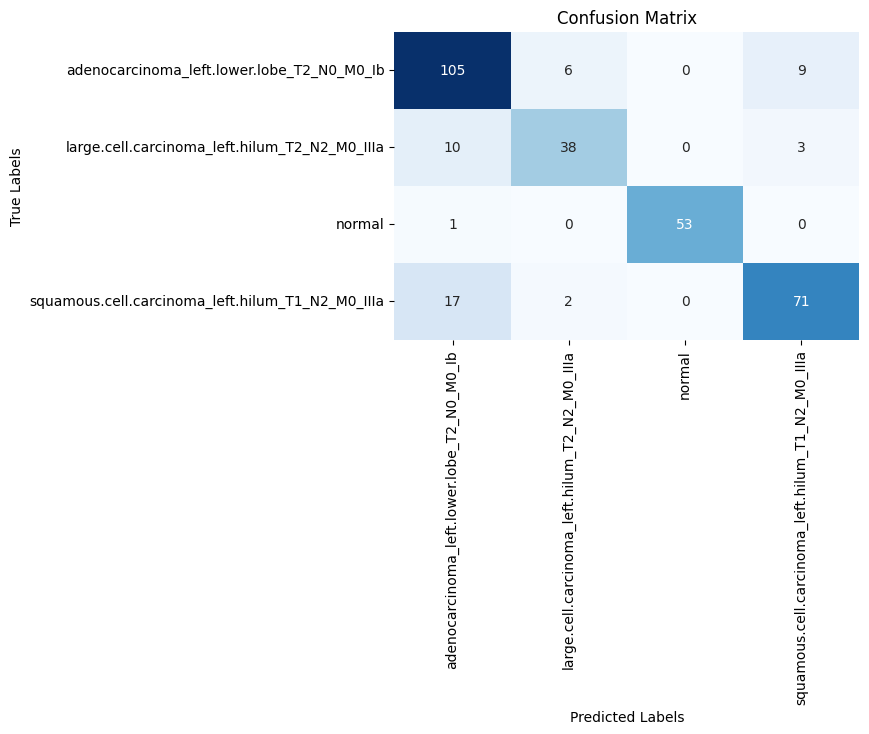

In [16]:
num_classes = len(class_names)
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
true_labels = []
predicted_probs = []

model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Processing test batches"):
        images = images.to(next(model.parameters()).device)
        outputs = model(images) 
        probabilities = torch.softmax(outputs, dim=1)
        
        predicted_probs.append(probabilities.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

predicted_probs = np.concatenate(predicted_probs, axis=0)  
true_labels = np.concatenate(true_labels, axis=0)          

if true_labels.ndim == 1:
    num_classes = predicted_probs.shape[1]
    true_labels_onehot = label_binarize(true_labels, classes=range(num_classes))
else:
    num_classes = true_labels.shape[1]
    true_labels_onehot = true_labels

try:
    if len(class_names) != num_classes:
        classes = [f"Class {i}" for i in range(num_classes)]
except NameError:
    classes = [f"Class {i}" for i in range(num_classes)]

Processing test batches: 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

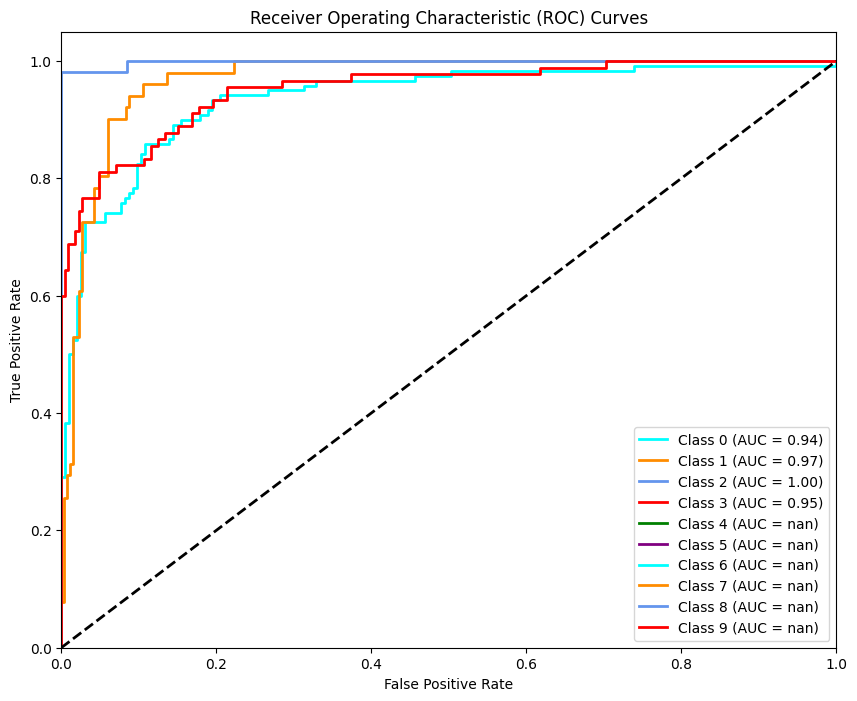

Saved ROC plot with only curves as 'roc_plot_no_labels.png'


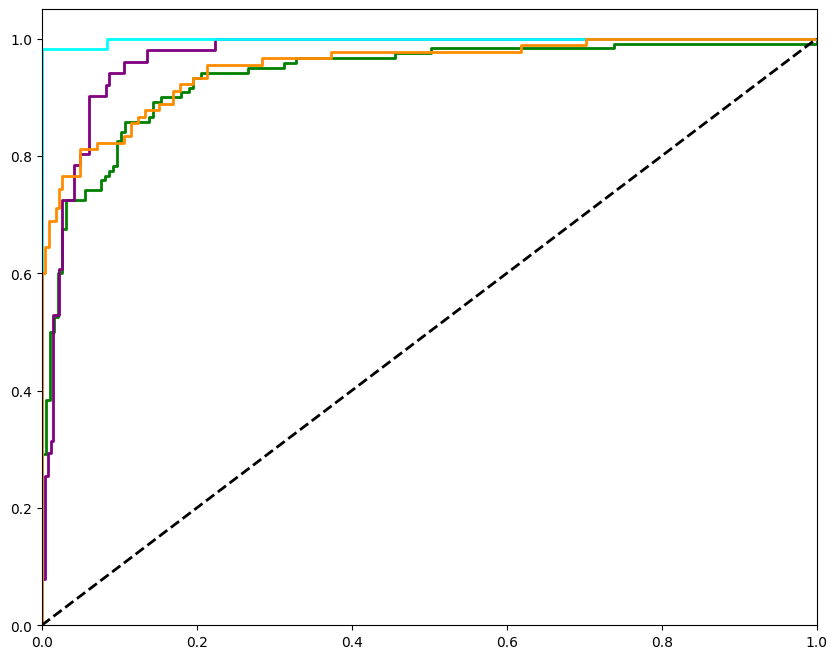

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.savefig("roc_plot_no_labels.png", bbox_inches='tight')
print("Saved ROC plot with only curves as 'roc_plot_no_labels.png'")
plt.show()

In [ ]:
excel_filename = "roc_data.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i in range(num_classes):
        df = pd.DataFrame({
            'FPR': fpr[i],
            'TPR': tpr[i]
        })
        df['AUC'] = roc_auc[i]  
        sheet_name = classes[i][:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"ROC metrics saved to {excel_filename}")

ROC metrics saved to roc_data.xlsx
